# Previsão com Modelos de Suavização Exponencial e Média Móvel

### - Moving Average
### - Exponencial Simples
### - Exponencial Duplo
### - Exponencial Triplo

In [1]:
import pandas as pd
from pandas import Grouper, DataFrame
from pandas.plotting import autocorrelation_plot

from typing import Tuple, List, Callable, Dict

import numpy as np
import os
from datetime import datetime

from matplotlib import pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import SimpleExpSmoothing, ExponentialSmoothing, Holt

import inspect
import warnings

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## Constantes

In [2]:
DIR_DATASET: str = os.path.join('datasets', 'dados-gerados')

DATASET_OEC_MPME = os.path.join(DIR_DATASET,  'oec_mpme.csv')

DAT_CORRENTE = datetime.today().strftime("%Y-%m-%d")

TEST_SPLIT_SIZE = 10

MEAN_SQUARED_METRIC = "mean_squeared"
MEAN_ABSOLUTE_METRIC = "mean_absolute"
R2_METRIC = "r2"

## Funções

In [3]:
def split_train_test_window_dataset(full_dataset: np.ndarray, test_percentual_size: int, window_size: int) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
        Separa os dados em treino e teste, gerando janelas onde os valores anteriores são as features e o valor atual o label.
                
        Args:
            full_dataset (ndarray): datafame contendo a série de desembolso
            test_percentual_size (int): percentual de dados para teste
            window_size (int): tamanho da janela utilizada na previsão.
            
        Returns:
            1) X_train - features (valores anteriores de desembolso) para treino.
            1) y_train - Label para treino, ou seja o valor desembolsado.
            2) X_test - features (valores anteriores de desembolso) para teste.
            3) y_test - Label da base de teste, será utilizado para avaliação da previsão
    """
    dataset_size: int = full_dataset.shape[0]
    cut_pos: int = round(dataset_size - (dataset_size * (test_percentual_size /100)))
    test_dataset_size: int = dataset_size - cut_pos
    
    y_train: np.ndarray = full_dataset[window_size : cut_pos]
    y_test: np.ndarray = full_dataset[cut_pos:]
    
    train_dataset_list = [full_dataset[ind : ind + window_size] for ind in range (cut_pos - window_size)]
    X_train = np.array(train_dataset_list)
    
    test_dataset_list = [full_dataset[cut_pos + ind - window_size:cut_pos + ind] for ind in range (test_dataset_size)]
    X_test = np.array(test_dataset_list)
    
    return X_train, y_train, X_test, y_test

In [4]:
def get_predictions_performance(y_pred: np.ndarray, y_true: np.ndarray, metric: str) -> float:
    """
        Retorna a a performance da previsão de acordo com a métrica informada.
        
        Args:
            y_pred (ndarray): vetor com os valores previstos.
            y_true (ndarray): vetor com os valores reais de desembolso.
            
        Returns:
            Medida de falha da previsão de acordo com a métrica escolhida. 
    """
    if metric == MEAN_ABSOLUTE_METRIC:
        return mean_absolute_error(y_true, y_pred)
    elif metric == MEAN_SQUARED_METRIC:
        return mean_squared_error(y_true, y_pred, squared=True)
    elif metric == R2_METRIC:
        return r2_score(y_true, y_pred)
    else:
        raise ValueError(f"Métrica informada é inválida {metric}")
        

In [10]:
def get_best_window_size(observations: np.ndarray, 
                         test_split_size: int,
                         pred_function: Callable, 
                         min_size: int = 2, max_size: int = 12,
                         metric: str = R2_METRIC) -> Tuple[int,float]:
    
    """
        Busca o melhor tamanho de janela para um mdelo de previsão informado.
        
        Args:
            observations (ndarray): Vetor com os valores desembolsados, ainda não preparados para previsão (sem janelas).
            test_split_size (int): percentual para separação entre treino e teste
            pred_function (Callabel): função que deverá ser chamada para previsão.
            min_size (int): menor tamanho da janela para busca
            max_size (int): tamanho máximo da janela para busca.
            metric (str): métrica utilizada para avaliação
            
        Returns:
            1) Tamanho da melhor janela.
            2) Medida da falha pra a melhor janela encontrada.
    """
    
    window_dict: Dict[int, float] = {}
    
    for w_size in range(min_size, max_size+1):
        predicted_list: List[float] = []
        _, _, X_test, y_test = split_train_test_window_dataset(observations, test_split_size, w_size)
        
        for p in range (len(X_test)):
            predicted_list.append(pred_function(X_test[p]))
        predicted: np.ndarray = np.array(predicted_list)
        value_metric = get_predictions_performance(predicted, y_test, metric)
        window_dict[w_size] = value_metric
    
    print(window_dict)
    best_w_size = 0
    if metric == R2_METRIC:
        best_value = -10000000
    elif metric == MEAN_ABSOLUTE_METRIC or metric == MEAN_SQUARED_METRIC:
        bet_value = 10000000
    else:
        raise ValueError(f"Métrica informada é inválida {metric}")
    
    for key in window_dict.keys():
        valor_atual: float = window_dict[key];
        if metric == R2_METRIC:
            if (valor_atual > best_value):
                best_value = valor_atual
                best_w_size = key
        elif metric == MEAN_ABSOLUTE_METRIC or metric == MEAN_SQUARED_METRIC:
            if (valor_atual < best_value):
                best_value = valor_atual
                best_w_size = key        
        
    return best_w_size, best_value
        

In [14]:
def execute_prevision(pred_function: Callable, window_size:int, observations: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
        Executa previsão de um modelo previamente construido.
        
        Args:
            pred_function (Callable): função que deverá ser chamada para previsão.
            window_size (int): tamanho da janela.
            observations (ndarray): vetor com os desembolsos, não preparado para previsão (sem janela)
            
        Returns:
            1) y_train - labels de treino.
            2) prediction - previsão do modelo
            3) y_test - desembolsos que realmente aconteceram para confronto com o previsto
    
    """
    
    X_train, y_train, X_test, y_test = split_train_test_window_dataset(observations, TEST_SPLIT_SIZE, window_size)
    prediction_list:List = []
    for t_index in range(len(X_test)):
        valor_previsto = pred_function(X_test[t_index])
        prediction_list.append(valor_previsto)
    prediction = np.array(prediction_list)
    
    return y_train, prediction, y_test

## Carrega Datasets

In [15]:
df_oec_mpme = pd.read_csv(DATASET_OEC_MPME, sep=';', decimal=',', parse_dates=True)
df_oec_mpme.index = pd.DatetimeIndex(df_oec_mpme.data_base)
df_oec_mpme["ano_mes"] = pd.DatetimeIndex(df_oec_mpme.data_base).strftime('%Y-%m')
df_oec_mpme_desembolso = df_oec_mpme[['desembolso','ano','mes', 'ano_mes']]

desembolso = df_oec_mpme_desembolso[["desembolso"]].to_numpy().squeeze()
desembolso_time = df_oec_mpme_desembolso[["ano_mes"]].to_numpy().squeeze()

#retirando tendencia com a série de diferença
diff_desembolso = np.diff(desembolso)

---

## Média Movel

In [16]:
def predict_by_moving_average(observations):
    return np.sum(observations) / observations.shape[0]

In [22]:
best_window_ma, best_metric_value_ma = get_best_window_size(desembolso, TEST_SPLIT_SIZE, predict_by_moving_average, min_size=2, max_size=25, metric=R2_METRIC)
print(f'Melhor Janela: {best_window_ma} com R2= {best_metric_value_ma}')

{2: -0.05416470040567223, 3: -0.17336320511767545, 4: -0.26866956184909463, 5: -0.13697891016732333, 6: -0.08469552544540937, 7: -0.12290814081115586, 8: -0.15645568019380707, 9: -0.10167581071817988, 10: -0.03754424518378552, 11: 0.04000805886688974, 12: 0.07216053724695337, 13: 0.03441348769787855, 14: 0.01824022941346437, 15: 0.004143007764233042, 16: 0.009279499985481832, 17: 0.007480607619094637, 18: -0.0407851239579069, 19: -0.12085857364778829, 20: -0.20737246095300343, 21: -0.2893228175569411, 22: -0.3617691612044627, 23: -0.41148114855764484, 24: -0.4711200273477929, 25: -0.5589628096599824}
Melhor Janela: 12 com R2= 0.07216053724695337


In [18]:
y_train, ma_prediction, y_true = execute_prevision(predict_by_moving_average, best_window_ma, desembolso)

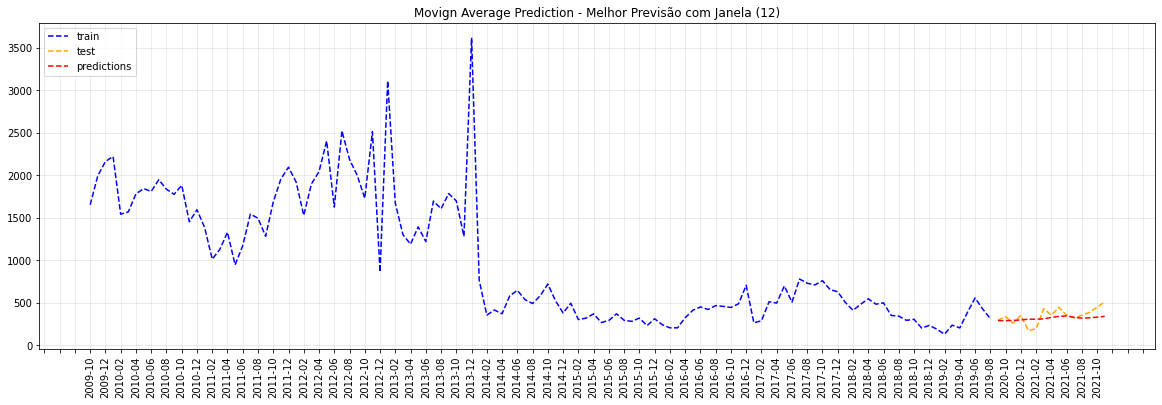

In [19]:
plt.figure(figsize=(20,6))
plt.xticks(rotation='vertical')
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(2))
plt.plot(desembolso_time[:len(y_train)], y_train, 'b--', label="train")
plt.plot(desembolso_time[-len(y_true):], y_true, color='orange', linestyle="--", label="test")
plt.plot(desembolso_time[-len(ma_prediction):], ma_prediction, 'r--', label="predictions")
plt.legend(loc='upper left')
plt.title(f"Movign Average Prediction - Melhor Previsão com Janela ({best_window_ma})")
plt.grid(alpha=0.3);

In [20]:
ma_mse = mean_squared_error(y_true, ma_prediction, squared=True)
ma_mae = mean_absolute_error(y_true, ma_prediction)
ma_r2 = r2_score(y_true, ma_prediction)
print(f'Mean Squared Error: {ma_mse} ')
print(f'Mean Absolute Error: {ma_mae}')
print(f'R2 Score: {ma_r2}')

Mean Squared Error: 7444.364736799774 
Mean Absolute Error: 69.25498146333332
R2 Score: 0.07216053724695337


#### Tentativa com a série estacionária da diferença

In [14]:
best_window_ma, best_metric_value_ma = get_best_window_size(diff_desembolso , TEST_SPLIT_SIZE, predict_by_moving_average, min_size=2, max_size=12, metric=R2_METRIC)

{2: -0.7930312528144821, 3: -0.43786277271428187, 4: -0.4882512983702496, 5: -0.21382301590509356, 6: -0.16229024272381976, 7: -0.1851161343035086, 8: -0.2641799894344823, 9: -0.13027479014485577, 10: -0.10508965937556103, 11: -0.0785638621905862, 12: -0.017840945796952612}


> Resultados piores

---

## Exponencial
1. Suavização exponencial única - sem tendência ou sazonalidade
2. Suavização exponencial dupla - captura tendência
3. Suavização Exponencial Tripla - captura tendência e sazonalidade

### Exponencial Único

In [23]:
def predict_by_simple_exponential(observations):
    single_exp_model = SimpleExpSmoothing(observations).fit(optimized=True)
    single_preds = single_exp_model.forecast(1)
    return single_preds[0]

In [29]:
best_window_exp_1, best_metric_value_exp_1 = get_best_window_size(desembolso, TEST_SPLIT_SIZE, predict_by_simple_exponential, min_size=2, max_size=24, metric=R2_METRIC)
print(f'Melhor Janela: {best_window_exp_1} com R2= {best_metric_value_exp_1}')

{2: -0.0541647631535207, 3: 0.10391605340945498, 4: 0.0037526826310525507, 5: 0.10135104511820914, 6: -0.0634896353328076, 7: -0.06810404699940631, 8: -0.2476098399362796, 9: -0.35014523501591155, 10: -0.3095990004686504, 11: -0.15068977836825437, 12: -0.32082733382986195, 13: -0.42620314764430356, 14: -0.30414111369555297, 15: -0.20466682846826134, 16: -0.30328311073253333, 17: -0.27046879102547194, 18: -0.24335844254030814, 19: -0.47508075595042487, 20: -0.44385130590129296, 21: -0.09898351670587413, 22: -0.10467367297382646, 23: -0.11009547086162974, 24: -0.12269695149388826}
Melhor Janela: 3 com R2= 0.10391605340945498


In [26]:
y_train, exp_1_prediction, y_true = execute_prevision(predict_by_simple_exponential, best_window_exp_1, desembolso)

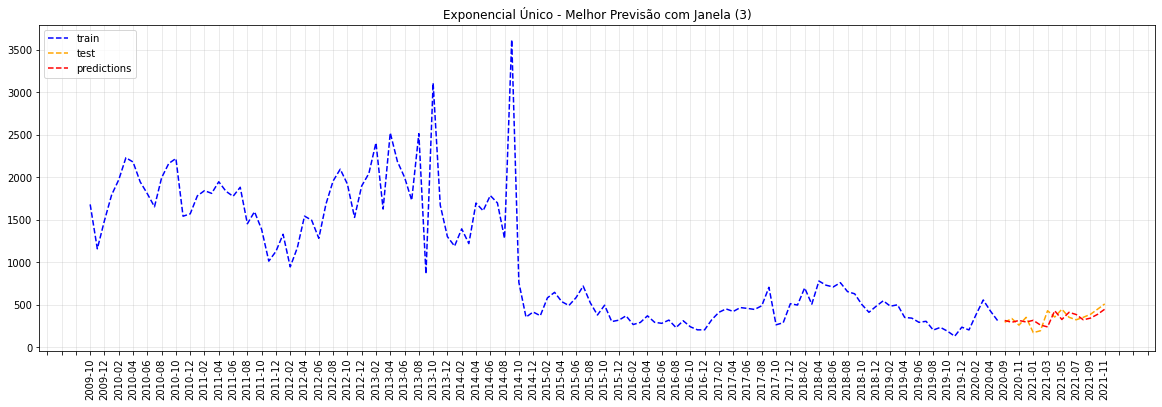

In [27]:
plt.figure(figsize=(20,6))
plt.xticks(rotation='vertical')
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(2))
plt.plot(desembolso_time[:len(y_train)], y_train, 'b--', label="train")
plt.plot(desembolso_time[-len(y_true):], y_true, color='orange', linestyle="--", label="test")
plt.plot(desembolso_time[-len(exp_1_prediction):], exp_1_prediction, 'r--', label="predictions")
plt.legend(loc='upper left')
plt.title(f"Exponencial Único - Melhor Previsão com Janela ({best_window_exp_1})")
plt.grid(alpha=0.3);

In [28]:
single_exp_mse = mean_squared_error(y_true, exp_1_prediction, squared=True)
single_exp_mae = mean_absolute_error(y_true, exp_1_prediction)
single_exp_r2 = r2_score(y_true, exp_1_prediction)
print(f'Mean Squared Error: {single_exp_mse} ')
print(f'Mean Absolute Error: {single_exp_mae}')
print(f'R2 Score: {single_exp_r2}')

Mean Squared Error: 7189.5796643718695 
Mean Absolute Error: 72.59387713427483
R2 Score: 0.10391605340945498


#### Tentativa com a série estacionária da diferença

In [23]:
best_window_exp_1, best_metric_value_exp_1 = get_best_window_size(diff_desembolso, TEST_SPLIT_SIZE, predict_by_simple_exponential, min_size=2, max_size=12, metric=R2_METRIC)

{2: -0.7930317309584913, 3: -1.0109158546673713, 4: -0.5839550967301814, 5: -0.2866203453153684, 6: -0.1909697869764051, 7: -0.20764366003696355, 8: -0.25468631944514386, 9: -0.14528543002456384, 10: -0.13257563730871302, 11: -0.08336435224660876, 12: -0.10426915071116771}


> Novamente resultados piores

---

### Exponencial Duplo

In [30]:
def predict_by_double_exponential(observations):
    double_exp_model = Holt(observations).fit(optimized=True)
    double_preds = double_exp_model.forecast(1)
    return double_preds[0]

In [32]:
best_window_double_exp, best_metric_value_double_exp = get_best_window_size(desembolso, TEST_SPLIT_SIZE, predict_by_double_exponential, min_size=2, max_size=24, metric=R2_METRIC)
print(f'Melhor Janela: {best_window_double_exp} com R2= {best_metric_value_double_exp}')

{2: -2.1856652773541665, 3: -0.9969305390657035, 4: -1.006676993640482, 5: -0.6968141826466034, 6: -0.4086520019360729, 7: -0.5154140106597755, 8: -0.5018932118054995, 9: -0.5236774368073369, 10: -0.4776309197250168, 11: -0.19820010128535248, 12: -0.44908267521719725, 13: -0.20283460582232737, 14: -0.11507816130710058, 15: -0.22416075567285954, 16: -0.32002091662764, 17: -0.29590424828951245, 18: -0.17937313757014572, 19: -0.27174461694304464, 20: -0.21153765612945374, 21: -0.09850542321069233, 22: -0.14291266310757145, 23: -0.20381894040951876, 24: -0.16047508641049735}
Melhor Janela: 21 com R2= -0.09850542321069233


In [33]:
y_train, double_exp_prediction, y_true = execute_prevision(predict_by_double_exponential, best_window_double_exp, desembolso)

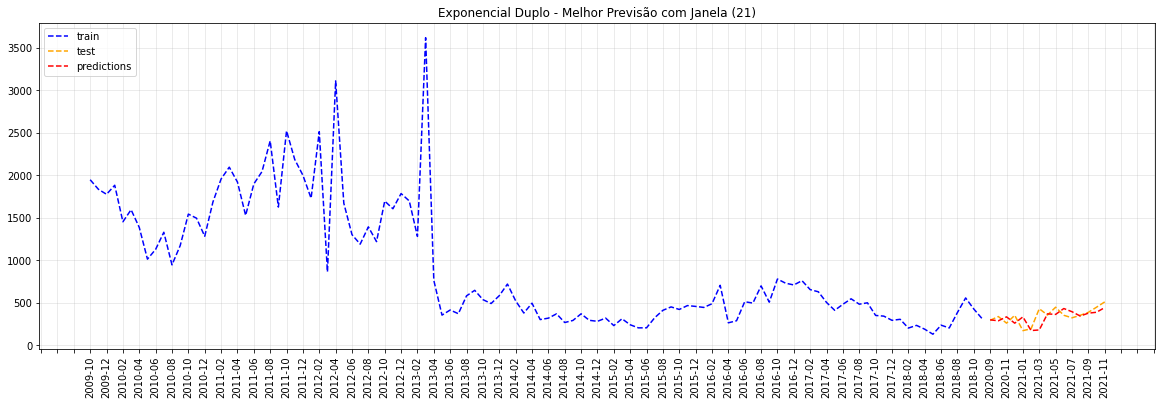

In [34]:
plt.figure(figsize=(20,6))
plt.xticks(rotation='vertical')
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(2))
plt.plot(desembolso_time[:len(y_train)], y_train, 'b--', label="train")
plt.plot(desembolso_time[-len(y_true):], y_true, color='orange', linestyle="--", label="test")
plt.plot(desembolso_time[-len(double_exp_prediction):], double_exp_prediction, 'r--', label="predictions")
plt.legend(loc='upper left')
plt.title(f"Exponencial Duplo - Melhor Previsão com Janela ({best_window_double_exp})")
plt.grid(alpha=0.3);

In [35]:
double_exp_mse = mean_squared_error(y_true, double_exp_prediction, squared=True)
double_exp_mae = mean_absolute_error(y_true, double_exp_prediction)
double_exp_r2 = r2_score(y_true, double_exp_prediction)
print(f'Mean Squared Error: {double_exp_mse} ')
print(f'Mean Absolute Error: {double_exp_mae}')
print(f'R2 Score: {double_exp_r2}')

Mean Squared Error: 8813.674524543861 
Mean Absolute Error: 69.70147397346611
R2 Score: -0.09850542321069233


#### Tentativa com a série estacinária da diferença

In [27]:
best_window_double_exp, best_metric_value_double_exp = get_best_window_size(diff_desembolso, TEST_SPLIT_SIZE, predict_by_double_exponential, min_size=2, max_size=12, metric=R2_METRIC)

C:\Users\gdutr\miniconda3\envs\forecast\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


{2: -8.089364072984967, 3: -3.8387191703359607, 4: -2.0343454534449963, 5: -2.479337016230244, 6: -1.494938014699244, 7: -1.0012882593969645, 8: -0.6440337725138978, 9: -0.8516745544632913, 10: -1.7630685212154242, 11: -6.563162199073495, 12: -1.513257219909077}


>Série da diferença com resultados piores.

---

### Exponencial Triplo

In [37]:
def predict_by_triple_exponential(observations):
    triple_exp_model = ExponentialSmoothing(observations,
                              trend="multiplicative",
                              seasonal="multiplicative",
                              seasonal_periods=12).fit(optimized=True)
    triple_preds = triple_exp_model.forecast(1)
    return triple_preds[0]

In [39]:
# Exponencial triplo exigia ao menos 2 ciclos sazonais
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    best_window_triple_exp, best_metric_value_triple_exp = get_best_window_size(desembolso, 
                                                                                TEST_SPLIT_SIZE, 
                                                                                predict_by_triple_exponential, 
                                                                                min_size=24, 
                                                                                max_size=48, 
                                                                                metric=R2_METRIC)
print(f'Melhor Janela: {best_window_triple_exp} com R2= {best_metric_value_triple_exp}')

{24: -1.3445514495554582, 25: -0.849748297188379, 26: -0.6487091972967924, 27: -0.16857279252942026, 28: -0.08329346502681911, 29: -0.10013086817336925, 30: -0.3496787430148016, 31: -1.2546809311204883, 32: -0.8963923748939027, 33: -1.2361025303095294, 34: -0.8605067452565156, 35: -0.6079709417864694, 36: -0.13608678110394123, 37: 0.368669025140686, 38: 0.44334037347245714, 39: 0.3038034090136099, 40: 0.38685555083316325, 41: 0.2459055852270654, 42: 0.3647357102646931, 43: 0.2783089993889273, 44: 0.2484433918342116, 45: 0.25826668857703916, 46: 0.2356419311641884, 47: 0.2649876235789911, 48: -0.0363787222905696}
Melhor Janela: 38 com R2= 0.44334037347245714


In [40]:
y_train, triple_exp_prediction, y_true = execute_prevision(predict_by_triple_exponential, best_window_triple_exp, desembolso)


C:\Users\gdutr\miniconda3\envs\forecast\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\gdutr\miniconda3\envs\forecast\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\gdutr\miniconda3\envs\forecast\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


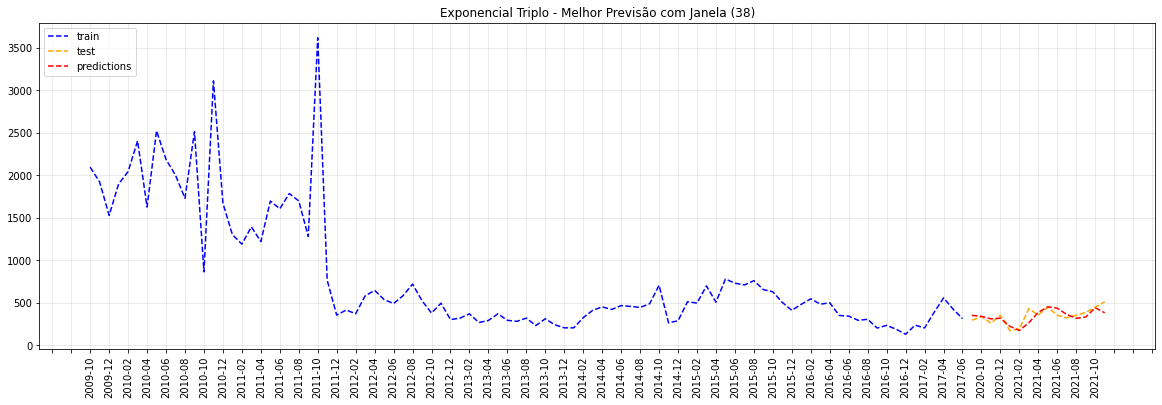

In [41]:
plt.figure(figsize=(20,6))
plt.xticks(rotation='vertical')
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(2))
plt.plot(desembolso_time[:len(y_train)], y_train, 'b--', label="train")
plt.plot(desembolso_time[-len(y_true):], y_true, color='orange', linestyle="--", label="test")
plt.plot(desembolso_time[-len(triple_exp_prediction):], triple_exp_prediction, 'r--', label="predictions")
plt.legend(loc='upper left')
plt.title(f"Exponencial Triplo - Melhor Previsão com Janela ({best_window_triple_exp})")
plt.grid(alpha=0.3);

In [42]:
triple_exp_mse = mean_squared_error(y_true, triple_exp_prediction, squared=True)
triple_exp_mae = mean_absolute_error(y_true, triple_exp_prediction)
triple_exp_r2 = r2_score(y_true, triple_exp_prediction)
print(f'Mean Squared Error: {triple_exp_mse} ')
print(f'Mean Absolute Error: {triple_exp_mae}')
print(f'R2 Score: {triple_exp_r2}')

Mean Squared Error: 4466.265405252257 
Mean Absolute Error: 50.8531873038726
R2 Score: 0.44334037347245714


#### Tentativa com a série estacionária da Diferença não foi possível porque exigia valores positivos

In [30]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    best_window_triple_exp, best_metric_value_triple_exp = get_best_window_size(diff_desembolso, TEST_SPLIT_SIZE, predict_by_triple_exponential, min_size=24, max_size=48, metric=R2_METRIC)

ValueError: endog must be strictly positive when usingmultiplicative trend or seasonal components.